In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
data_path = 'data/30MIN_Full_Dataset.csv'
data = pd.read_csv(data_path)
data = data[(data['timestamp'] >= '2018-08-22') & (data['timestamp'] <= '2019-05-13')]
data = data.drop(['timestamp'], axis=1)

data.head()

,price_open,price_high,price_low,price_close,volume_traded,vader_pos,vader_neg,vader_neu,vader_compound,pos_count,neg_count,neu_count,MACD,SMA,OBV,RSI,MFI,pos_keywords_occur,neg_keywords_occur
17040,6478.99,6481.99,6450.76,6457.29,120.249956,0.000,0.000,1.000,0.0000,0,0,0,157.989424,6474.366,-43402.31757,52.946061,93.733125,0,0
17041,6457.21,6478.99,6436.66,6464.71,169.194126,0.000,0.000,1.000,0.0000,0,0,0,158.581333,6472.538,-43233.12345,51.899205,92.641902,0,0
17042,6464.71,6843.35,6464.71,6775.93,1478.261556,0.000,0.000,1.000,0.0000,0,0,0,183.408000,6532.524,-41754.86189,70.871024,89.039914,0,0
17043,6776.03,6831.04,6750.94,6804.45,306.838012,0.153,0.000,0.847,0.8757,1,0,0,185.683099,6596.330,-41448.02388,70.504672,85.825632,1,1
17044,6804.45,6906.81,6685.07,6705.90,857.704890,0.025,0.049,0.926,-0.3304,0,1,0,177.821561,6641.656,-42305.72877,63.369511,93.989542,1,6


In [4]:
'''Price Data:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'MACD', 'SMA', 'OBV', 'RSI', 'MFI', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator + Sentiment Indicator:'''
# data_features = data.drop(['price_close', 'pos_count', 'neg_count', 'neu_count'], axis=1)

'''Price Data + Technical Indicator in 30 MIN data:'''
# data_features = data.drop(['price_close', 'vader_pos', 'vader_neg', 'vader_neu', 'vader_compound', 'pos_count', 'neg_count', 'neu_count', 'pos_keywords_occur', 'neg_keywords_occur'], axis=1)


'''Price Data + Selected Features'''
data_features = data.drop(['price_close', 'MFI', 'vader_compound',	'pos_count', 'neg_count', 'neu_count'], axis=1)

data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))

In [5]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

LSTM_window_size = 20

feature, label = split_data(feature, label, LSTM_window_size)

train_size = int(0.8 * len(label))

X_train, X_test = feature[:train_size], feature[train_size:]
y_train, y_test = label[:train_size], label[train_size:]

print(X_train.shape, X_test.shape)

(10121, 20, 13) (2531, 20, 13)


In [6]:
model = \
    keras.Sequential([
        layers.LSTM(512),
        layers.Dense(1)
    ])


2022-11-01 16:59:09.161185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 16:59:09.169446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 16:59:09.169705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 16:59:09.170278: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
DECAY_RATE = -0.6

def lr_scheduler(epoch, lr):
    if epoch % 10== 0 and epoch > 0:
        lr *= tf.math.exp(DECAY_RATE)
    
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                shuffle=False,
                )

2022-11-01 16:59:09.738839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-11-01 16:59:11.389797: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400


80/80 [==============================] - 3s 10ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173
Epoch 2/25
80/80 [==============================] - 1s 10ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850
Epoch 3/25
80/80 [==============================] - 1s 10ms/step - loss: 0.0064 - root_mean_squared_error: 0.0801
Epoch 4/25
80/80 [==============================] - 1s 10ms/step - loss: 0.0053 - root_mean_squared_error: 0.0727
Epoch 5/25
80/80 [==============================] - 1s 10ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631
Epoch 6/25
80/80 [==============================] - 1s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512
Epoch 7/25
80/80 [==============================] - 1s 10ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343
Epoch 8/25
80/80 [==============================] - 1s 10ms/step - loss: 6.3651e-04 - root_mean_squared_error: 0.0252
Epoch 9/25
80/80 [==============================] - 1s 10ms/step - loss: 4.4806e-04 - root_mean

In [8]:
pred_LSTM = model.predict(X_test)

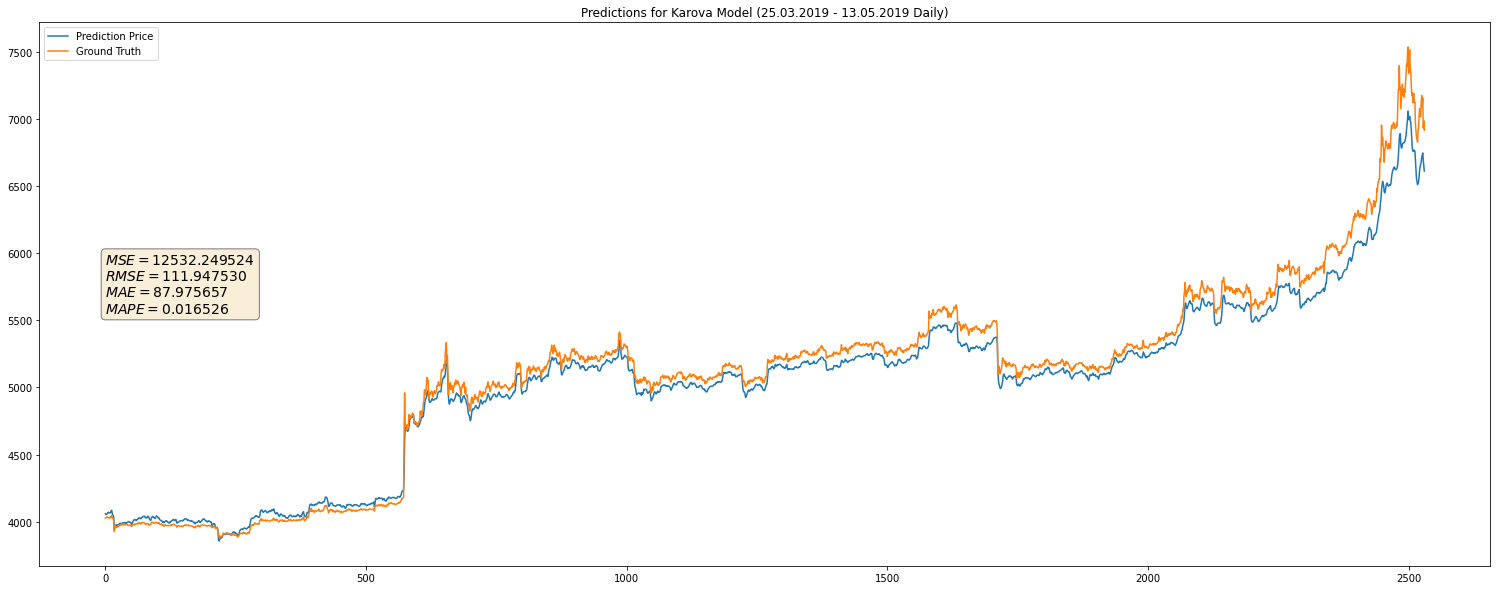

In [9]:
prediction = np.array(pred_LSTM)
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(pred_prices, true_prices)
rmse = mean_squared_error(pred_prices, true_prices, squared=False)
mae = mean_absolute_error(pred_prices, true_prices)
mape = mean_absolute_percentage_error(pred_prices, true_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae),
    '$MAPE=%f$' % (mape)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('Predictions for Karova Model (25.03.2019 - 13.05.2019 Daily)')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 6000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()